In [99]:
# 說明：設置環境、import 套件
import pandas as pd
import numpy as np
import pprint 
import matplotlib.pyplot as plt
from matplotlib import pylab
%pylab inline
#plt.style.use('ㄎ')
pylab.rcParams['figure.figsize'] = (20, 8)

Populating the interactive namespace from numpy and matplotlib


D:\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sum']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 原始資料說明 - 1
- 區間：去年 09/01 - 11/10，七一天
    - 這份資料區間以方便分析為主，所以 71 天只是 1.0 版本，之後會擴張到整學期
- 間隔：一小時一筆
- 地點：所有的學生宿舍，以下我是針對十二舍做
- 一個地點的筆數：每棟大樓共 71(day) * 24(hr) = 1704 筆
- 總筆數 = 1704 * 17 = 28968 筆

In [100]:
# Global variables
CostRate = 3 # 一度電多少錢（估算，實際還要再確認）

In [101]:
filename = '[new]Dorm12_hour_20170801_20180131.csv'
file = open('./Electricity_analytics-2017/02dataset/'+filename, encoding = 'utf8')
df = pd.read_csv(file)
path = './Electricity_analytics-2017/02dataset/{}'.format(file)
del df['Unnamed: 0']
df.head()

,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Week,Time,Cost
0,2017/08/01 00:00,S,D12,main,dorm,64.0,2017-08-01,2,31,00:00,192.0
1,2017/08/01 01:00,S,D12,main,dorm,59.0,2017-08-01,2,31,01:00,177.0
2,2017/08/01 02:00,S,D12,main,dorm,55.0,2017-08-01,2,31,02:00,165.0
3,2017/08/01 03:00,S,D12,main,dorm,55.0,2017-08-01,2,31,03:00,165.0
4,2017/08/01 04:00,S,D12,main,dorm,51.0,2017-08-01,2,31,04:00,153.0


### 原始資料說明 - 2
- index: ['﻿時  間', '區 域', '館 舍 別', '迴 路 別', '用電別', '用電量(單位:度)']

### 人工資料前處理：改變欄位名稱
#### 改變的原因
- 原始的資料有空白在字串裡，會造成一些麻煩
- 英文的名稱，可以在Pandas寫Code時較為方便(才能用 df.Usage的指令)

#### 改了什麼
- 我用Number(Excel)的尋找取代功能，把資料轉成英文，以下括弧表示原始資料的命名
    - 區域：southArea(南區), northArea(北區)
    - 迴 路 別: mainLoop（主迴路）, familyMart（1F便利超商）, club（社團）, socialHall（閱覽交誼廳）, studentHall（學生交誼廳）, streetLight(環校路燈),
    - 館舍： dorm_13（學生十三舍）,(7,8,9,10,11,12 以此類推), dorm_graduate_2（研二）, dorm_87（學生七舍＿八舍）, dorm_13_graduate_1(11與研一), dorm_chu（竹軒）
    - 用電別：rent（外租）, dorm（宿舍）, admin(行政)

Adrain建議: 這部分應該透過 Pandas 寫好，才可以省下每筆資料要手動處理的時間

---
# 以下開始，正式透過 Pandas 來處理 / 分析資料

### 新增欄位：由DateTime的資訊，新增日期、時間、Weekday、Week
- def generate_date_time_columns(df)
    - 放進一個含有 DateTime 欄位的 df, 並寫且回傳新增 Date, Time, Weekday, Week的欄位
- Date, Time: 為了之後更方便用日期、時間去存取，分群比較。
- Weekday: 為了去了解週一到週日的用電變化
- Weekday: 為了後續容易掌握每週變化

In [102]:
def generate_date_time_columns(df):
    if('DateTime' in df.columns):
            length = len(df.DateTime.str[:])
            if(length >= 10):
                df['Date'] = df.DateTime.str[:10]
                df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
                df['Weekday'] = df['Date'].dt.dayofweek + 1
                df['Week'] = df['Date'].dt.week
            if(length >= 11):
                df['Time'] = df.DateTime.str[11:]
            print('Columns #Date, #Time, #Weekday, #Week has been generated from DateTime and added to DataFrame')
    else:
        print('DataTime not in column. Please rename columns name.')
    return df

In [103]:
df = generate_date_time_columns(df)
df.head()

Columns #Date, #Time, #Weekday, #Week has been generated from DateTime and added to DataFrame


,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Week,Time,Cost
0,2017/08/01 00:00,S,D12,main,dorm,64.0,2017-08-01,2,31,00:00,192.0
1,2017/08/01 01:00,S,D12,main,dorm,59.0,2017-08-01,2,31,01:00,177.0
2,2017/08/01 02:00,S,D12,main,dorm,55.0,2017-08-01,2,31,02:00,165.0
3,2017/08/01 03:00,S,D12,main,dorm,55.0,2017-08-01,2,31,03:00,165.0
4,2017/08/01 04:00,S,D12,main,dorm,51.0,2017-08-01,2,31,04:00,153.0


In [104]:
# cost_rate：一度電大概多少錢
def generate_cost_columns(df, cost_rate):
    df['Cost'] = df.Usage * cost_rate
    print('Column "Cost" had been generated!')
    return df

In [105]:
df = generate_cost_columns(df, CostRate)
df.head()

Column "Cost" had been generated!


,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Week,Time,Cost
0,2017/08/01 00:00,S,D12,main,dorm,64.0,2017-08-01,2,31,00:00,192.0
1,2017/08/01 01:00,S,D12,main,dorm,59.0,2017-08-01,2,31,01:00,177.0
2,2017/08/01 02:00,S,D12,main,dorm,55.0,2017-08-01,2,31,02:00,165.0
3,2017/08/01 03:00,S,D12,main,dorm,55.0,2017-08-01,2,31,03:00,165.0
4,2017/08/01 04:00,S,D12,main,dorm,51.0,2017-08-01,2,31,04:00,153.0


### 將資料切成三份
原本的資料集包含不同種類（宿舍、外租、行政）的欄位，而因為我們要專注分析宿舍用電，所以將資料切成三份

In [106]:
df_dorm = df[df.Type == 'dorm'] #以下專注在 df_dorm的分析
df_rent = df[df.Type == 'rent']
df_admin = df[df.Type == 'admin']

### 處理 df_dorm 的離群值

In [107]:
# 找離群值：找出最大的五個值，用肉眼可以看出離群值
df_dorm.sort_values('Usage')[-5:]
# 找出極大離群值的index

,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Week,Time,Cost
2537,2017/11/14 21:00,S,D12,main,dorm,230.0,2017-11-14,2,46,21:00,690.0
1006,2017/09/11 22:00,S,D12,main,dorm,238.5,2017-09-11,1,37,22:00,715.5
2615,2017/11/18 06:00,S,D12,main,dorm,271.5,2017-11-18,6,46,06:00,814.5
2516,2017/11/13 23:00,S,D12,main,dorm,352.0,2017-11-13,1,46,23:00,1056.0
2534,2017/11/14 17:00,S,D12,main,dorm,6055569.0,2017-11-14,2,46,17:00,18166707.0


In [108]:
df_dorm.sort_values('Usage')[:5]
# 找出缺值的index並處理掉

,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Week,Time,Cost
2558,2017/11/15 18:00,S,D12,main,dorm,3.0,2017-11-15,3,46,18:00,9.0
2492,2017/11/12 21:00,S,D12,main,dorm,7.0,2017-11-12,7,45,21:00,21.0
2533,2017/11/14 16:00,S,D12,main,dorm,9.5,2017-11-14,2,46,16:00,28.5
2528,2017/11/14 11:00,S,D12,main,dorm,10.5,2017-11-14,2,46,11:00,31.5
2485,2017/11/12 14:00,S,D12,main,dorm,12.0,2017-11-12,7,45,14:00,36.0


In [109]:
df_dorm[2520:2540]

,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Week,Time,Cost
2520,2017/11/14 03:00,S,D12,main,dorm,62.500,2017-11-14,2,46,03:00,1.875000e+02
2521,2017/11/14 04:00,S,D12,main,dorm,60.500,2017-11-14,2,46,04:00,1.815000e+02
2522,2017/11/14 05:00,S,D12,main,dorm,54.500,2017-11-14,2,46,05:00,1.635000e+02
2523,2017/11/14 06:00,S,D12,main,dorm,46.500,2017-11-14,2,46,06:00,1.395000e+02
2524,2017/11/14 07:00,S,D12,main,dorm,48.000,2017-11-14,2,46,07:00,1.440000e+02
2525,2017/11/14 08:00,S,D12,main,dorm,50.000,2017-11-14,2,46,08:00,1.500000e+02
2526,2017/11/14 09:00,S,D12,main,dorm,46.000,2017-11-14,2,46,09:00,1.380000e+02
2527,2017/11/14 10:00,S,D12,main,dorm,39.500,2017-11-14,2,46,10:00,1.185000e+02
2528,2017/11/14 11:00,S,D12,main,dorm,10.500,2017-11-14,2,46,11:00,3.150000e+01
2529,2017/11/14 12:00,S,D12,main,dorm,75.500,2017-11-14,2,46,12:00,2.265000e+02


In [112]:
#在離群值附近的資料加總起來取平均，替代為該欄
sum = 0
num = 0
avg = 0
for i in range(2531, 2534):
    sum = sum + df_dorm['Usage'][i]
    num = num+1
for j in range(2535, 2536):
    sum = sum + df_dorm['Usage'][j]
    num = num+1
avg = sum/num
avg

48.375

In [117]:
# 手動改離群值，如果離群值太多得用更完整的方式
df_dorm.loc[2534,'Usage']  = avg #  0.87 約是前後的值得大小
df_dorm.loc[2534,'Cost']  = df_dorm.loc[2534,'Usage'] * CostRate # 記得連Cost 一起改過來
df_dorm.iloc[2534]

DateTime       2017/11/14 17:00
Area                          S
Building                    D12
Loop                       main
Type                       dorm
Usage                    48.375
Date        2017-11-14 00:00:00
Weekday                       2
Week                         46
Time                      17:00
Cost                    145.125
Name: 2534, dtype: object

In [118]:
df_dorm['Usage'][2520:2541]

2520     62.500
2521     60.500
2522     54.500
2523     46.500
2524     48.000
2525     50.000
2526     46.000
2527     39.500
2528     10.500
2529     75.500
2530     49.125
2531     48.500
2532     47.500
2533      9.500
2534     48.375
2535     88.000
2536     77.000
2537    230.000
2538    115.000
2539    109.000
2540     83.000
Name: Usage, dtype: float64

In [119]:
# 這天的離群值，猜測來自之前欄位的位移
# 驗證：看之前欄位的值，有2145筆是零
print(df.iloc[2500:2600].Usage.value_counts())

50.000     5
51.000     4
46.000     4
41.000     3
76.000     2
88.000     2
52.500     2
59.500     2
75.000     2
48.000     2
83.000     2
62.500     2
44.500     2
92.500     1
75.500     1
115.000    1
230.000    1
77.000     1
48.375     1
9.500      1
45.500     1
60.000     1
47.500     1
44.000     1
48.500     1
49.125     1
10.500     1
99.500     1
39.500     1
51.500     1
          ..
141.000    1
140.000    1
113.000    1
108.000    1
95.000     1
90.000     1
80.000     1
71.500     1
76.500     1
73.000     1
105.500    1
53.000     1
61.500     1
45.000     1
74.000     1
55.000     1
49.000     1
43.500     1
40.000     1
38.000     1
59.000     1
3.000      1
183.000    1
101.000    1
106.000    1
114.000    1
112.000    1
97.000     1
72.500     1
57.500     1
Name: Usage, Length: 79, dtype: int64


### 了解每個欄位有多少種不同的值
因為Pandas似乎只有內建針對特定欄位的 unique ，而沒有把所有欄位的Unique 一次列出來的功能，
就自己寫一個

In [120]:
# 用自訂函式去理解DF中每個欄位有哪幾種類別的值
def understand(df):
    for col_name in df.columns:
        print ('>>> "{}" has {} unique values:'.format(col_name, len(df[col_name].unique())))
        if(len(df[col_name].unique())<50):
            pprint.pprint(df[col_name].unique())
        else:
            pprint.pprint('The value is more than 50 so wont be list here :P')
        print('\n')
understand(df_dorm)

>>> "DateTime" has 4409 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Area" has 1 unique values:
array(['S'], dtype=object)


>>> "Building" has 1 unique values:
array(['D12'], dtype=object)


>>> "Loop" has 1 unique values:
array(['main'], dtype=object)


>>> "Type" has 1 unique values:
array(['dorm'], dtype=object)


>>> "Usage" has 371 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Date" has 184 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Weekday" has 7 unique values:
array([2, 3, 4, 5, 6, 7, 1], dtype=int64)


>>> "Week" has 27 unique values:
array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52,  1,  2,  3,  4,  5], dtype=int64)


>>> "Time" has 24 unique values:
array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00',

# Part 2 Dorm 12 分析
我們先嘗試建立一個對於交大十二舍(Dorm 12)的分析，接著把這樣的分析方式寫成 general function()，套用到其他宿舍上

In [121]:
df_dorm_12 = df[df.Building == 'D12']

### 基本資訊

In [122]:
df_dorm_12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4409 entries, 0 to 4408
Data columns (total 11 columns):
DateTime    4409 non-null object
Area        4409 non-null object
Building    4409 non-null object
Loop        4409 non-null object
Type        4409 non-null object
Usage       4409 non-null float64
Date        4409 non-null datetime64[ns]
Weekday     4409 non-null int64
Week        4409 non-null int64
Time        4409 non-null object
Cost        4409 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 413.3+ KB


In [123]:
understand(df_dorm_12)

>>> "DateTime" has 4409 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Area" has 1 unique values:
array(['S'], dtype=object)


>>> "Building" has 1 unique values:
array(['D12'], dtype=object)


>>> "Loop" has 1 unique values:
array(['main'], dtype=object)


>>> "Type" has 1 unique values:
array(['dorm'], dtype=object)


>>> "Usage" has 371 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Date" has 184 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Weekday" has 7 unique values:
array([2, 3, 4, 5, 6, 7, 1], dtype=int64)


>>> "Week" has 27 unique values:
array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52,  1,  2,  3,  4,  5], dtype=int64)


>>> "Time" has 24 unique values:
array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00',

In [124]:
df_dorm_12.Usage.describe() # 統計上了解用電狀況

count    4409.000000
mean       72.106940
std        40.649619
min         3.000000
25%        40.000000
50%        66.500000
75%        98.000000
max       352.000000
Name: Usage, dtype: float64

# 2.1 十二舍繪圖分析
## 了解變化
- 了解各周的變化：
- 了解星期一在每週的變化
- 了解日用電隨小時的變化：平均
    - 每週平均比較
    - 各週星期一比較
- 成長率
    - 每星期一的變化
    - 每小時變化：抓出突然用電

## 異常值
- 最大值
- 最小值

## 多館舍比較
- 日夜用電比
- Box Plot


In [125]:
# 12舍的總電費（假設一度 3 元）
money = df_dorm_12.groupby('Date').sum().reset_index().Cost.sum()
date = df_dorm_12.Date.unique()
print('If one degree electricity costs {} NTD, from {} to {} ({} day), dorm 12 costs {} NTD'.format(CostRate,str(date[-1])[:10],str(date[0])[:10],len(date),money))

If one degree electricity costs 3 NTD, from 2018-01-31 to 2017-08-01 (184 day), dorm 12 costs 953758.5 NTD


In [126]:
df_dorm_12.to_csv('./Electricity_analytics-2017/02dataset/[Detailed]'+filename, encoding='utf-8')

### 圖一：每個小時的用電，71天（Line Plot）
#### 觀察
- 週末的時候（藍線最高點），通常用電比較低
- 圖片中間有個低潮，猜測是國慶連假
- 隨著冬天而下降
- 資料波動大

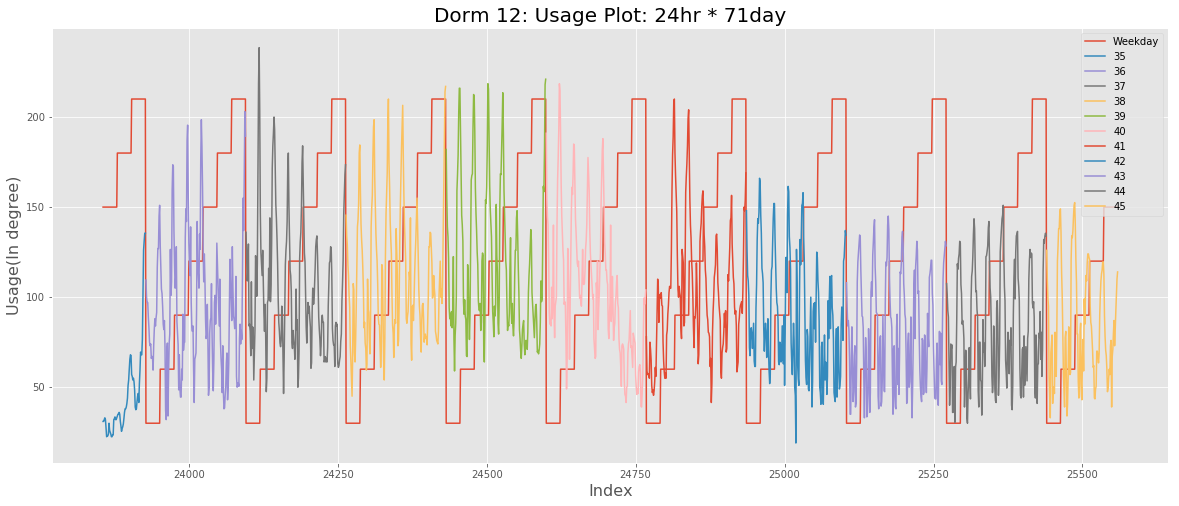

In [35]:
# 71 天每小時的用電資料 (1704個點)

(df_dorm_12.Weekday * 30).plot(legend = True)
# plt.xlabel('index')

df_dorm_12.groupby(['Week']).Usage.plot(legend = True)
#.Usage.plot(legend = True)
plt.title('Dorm 12: Usage Plot: 24hr * 71day', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Index',fontsize = 16)


In [37]:
df_dorm_12.sort_values('Cost').plot()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

### 圖二：最高日用電 
討論極端值的成因

In [14]:
df_dorm_12_dailysum = df_dorm_12.groupby('Date').sum()
df_dorm_12_dailysum.Weekday = df_dorm_12_dailysum.Weekday/24
df_dorm_12_dailysum.Usage.plot.bar(legend = True,color = cGreen)
plt.title('Dorm 12: Total Daily Usage', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Date',fontsize = 16)

NameError: name 'df_dorm_12' is not defined

In [15]:
# 最高用電的幾天是...
# 為什麼這幾天會比較高呢？
print('Top 10 daily TOTAL use of dorm 12. From 9.01 - 11.10')
print(df_dorm_12_dailysum.sort_values('Usage')[-10:])
# print('Top 10 daily AVERAGE use of dorm 12. From 9.01 - 11.10')
# print(df_dorm_12_dailymean_sorted[-10:])

Top 10 daily TOTAL use of dorm 12. From 9.01 - 11.10


NameError: name 'df_dorm_12_dailysum' is not defined

觀察：其實最高用電的前十個日子，大多發生在九月十月，而且有連續的現象！

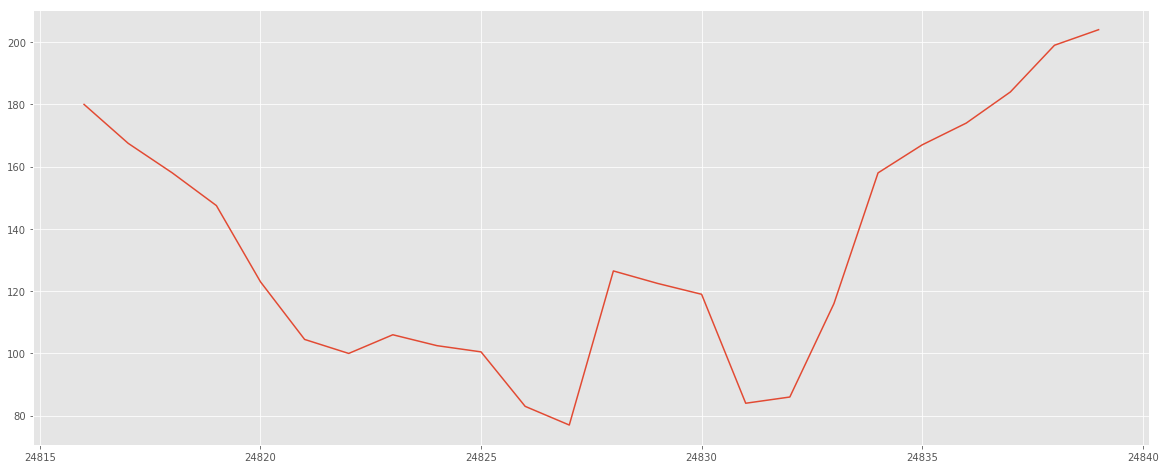

In [118]:
# 10.11 的用電繪圖
df_dorm_12[df_dorm_12.Date == '2017-10-11'].Usage.plot()
# xticks = list(df_dorm_12.Time.unique()) # bug to fix!!
# 不正常的地方：中午高峰

In [119]:
# 哪小時最耗電？
df_dorm_12.sort_values('Usage')[-100:].Time.value_counts()

22:00    26
23:00    23
21:00    20
00:00    14
20:00    10
19:00     4
01:00     3
Name: Time, dtype: int64

,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Time,Week,Cost
24118,2017/09/11 22:00,southArea,dorm_12,mainLoop,dorm,238.5,2017-09-11,1,22:00,37,715.5


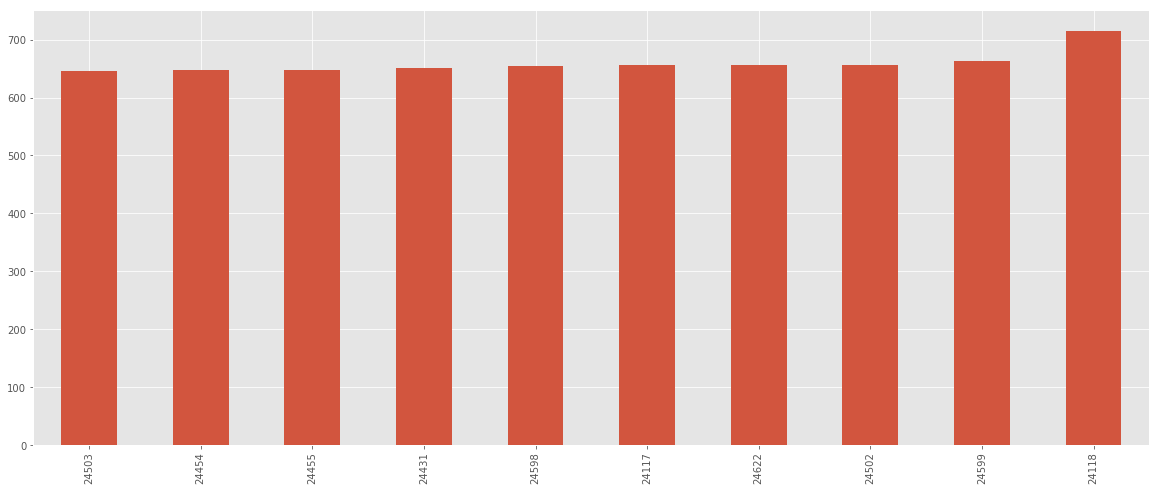

In [137]:
# Top 10 用電
# 看一下特高用電有多誇張，結果其實還好
df_dorm_12.sort_values('Usage')[-10:].Cost.plot.bar(color = cRed)
#發現有一小時真的特耗電

df_dorm_12.sort_values('Usage')[-1:]
# 2017/09/11 22:00 用電是 238.5, (12舍平均用電是96)

2017/9/11 為什麼用那麼多電呢？
我去查了日曆，原來是開學日的十點（一起打電動？煮火鍋？）

In [138]:
# 五十天中，星期幾最耗電？
df_dorm_12.groupby('Date').mean().sort_values('Usage')[-50:].Weekday.value_counts()

3    10
4     8
2     8
5     7
1     7
7     6
6     4
Name: Weekday, dtype: int64

### 圖三：平均用電變化 - 依Weekday看
#### 觀察
- 週六大家回家，平均用電最低
- 週日回宿舍，用電比週六週五高

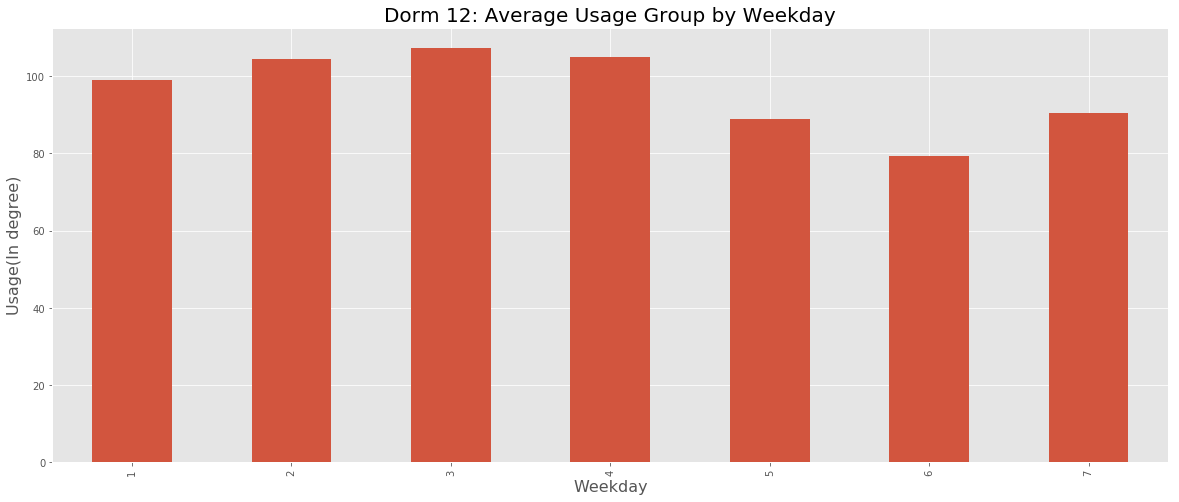

In [155]:
df_dorm_12_byWeekday = df_dorm_12.groupby('Weekday').mean()
df_dorm_12_byWeekday.Usage.plot.bar(legend = False,color = cRed)

plt.title('Dorm 12: Average Usage Group by Weekday', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Weekday',fontsize = 16)

### 圖三：各週用電變化 - 依Weekday看

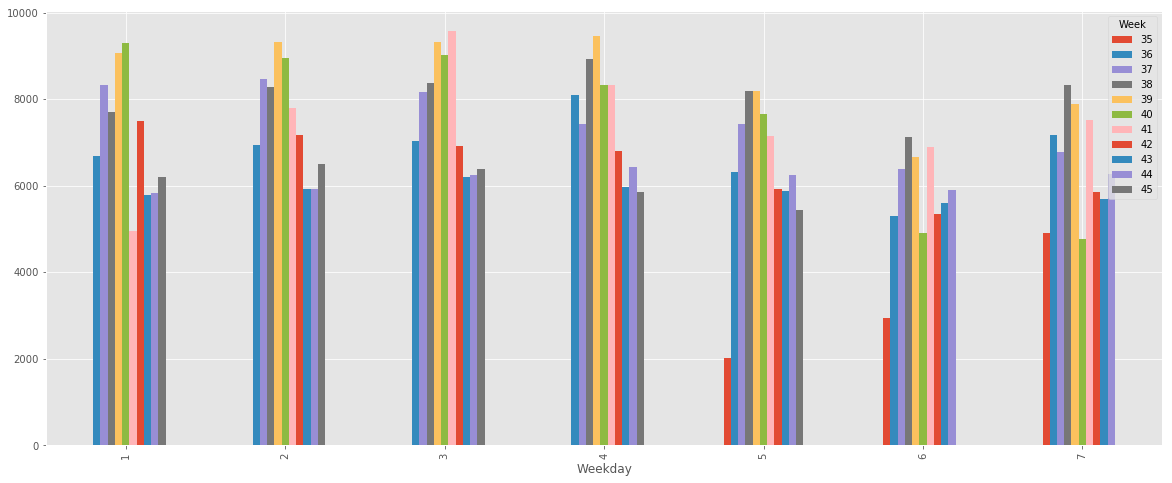

In [131]:
df_dorm_12.groupby(['Weekday','Week']).Cost.sum().unstack().plot.bar(legend = True)
#.Usage.plot(legend = True)
# 跟上一張圖的差別：可以看各周的變化

In [132]:
# 注意：取資料時，週五多一天
df_dorm_12.Weekday.value_counts()

5    264
7    240
6    240
4    240
3    240
2    240
1    240
Name: Weekday, dtype: int64

In [11]:
# df_dorm_12.groupby('Date').sum().Usage.plot.bar()
df_dorm_12.groupby('Week').mean().Cost.plot.bar(legend = True, color = cGreen)
plt.title('Every Week total Cost', fontsize = 20)
pylab.ylabel('Cost(NTD)',fontsize = 16)
pylab.xlabel('Week',fontsize = 16)

NameError: name 'df_dorm_12' is not defined

### 圖四：平均用電變化 - 依小時看

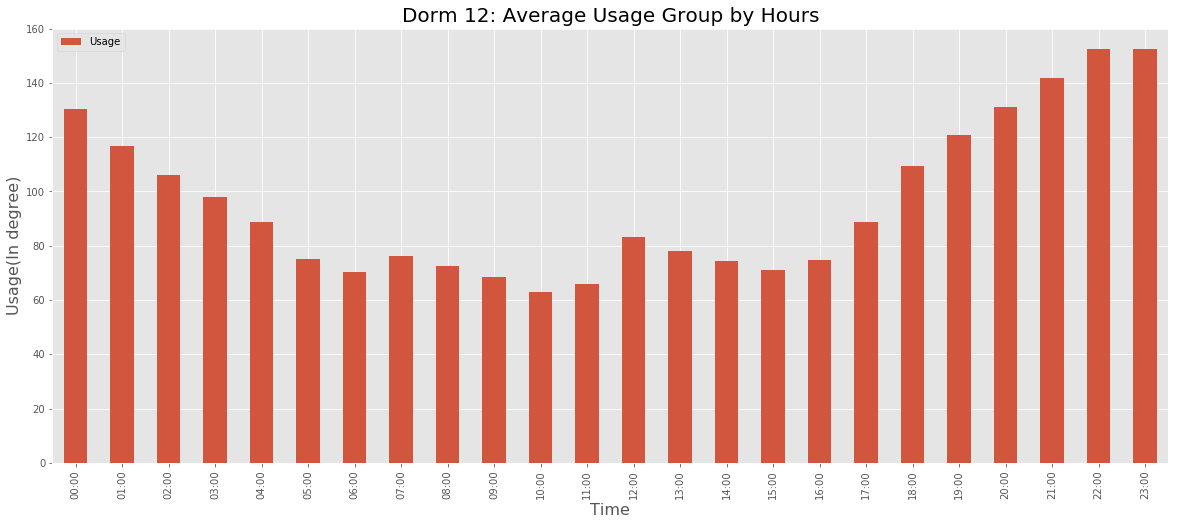

In [154]:
df_dorm_12.groupby('Time').Usage.mean().plot.bar(legend = True, color = cRed)
plt.title('Dorm 12: Average Usage Group by Hours', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Time',fontsize = 16)

### 觀察
- 這張是我覺得最有趣的，想法：可以拿去跟男生十舍比，看十二舍的人是不是比較早睡（省電）
- 最高用電落在晚上十一點到十二點。十二點會關燈。
- 關燈之後的下跌應該就是人為用電的減少（去睡覺了），人為用電除了桌電、吹風機以外，不知道洗澡熱水器有沒有被算在內？
- 早上七點起床有個Peak，可能是洗澡或開燈
- 中午十二點也有Peak，可能是回宿舍吃中飯
- 晚上六點開燈，所以用電升幅大

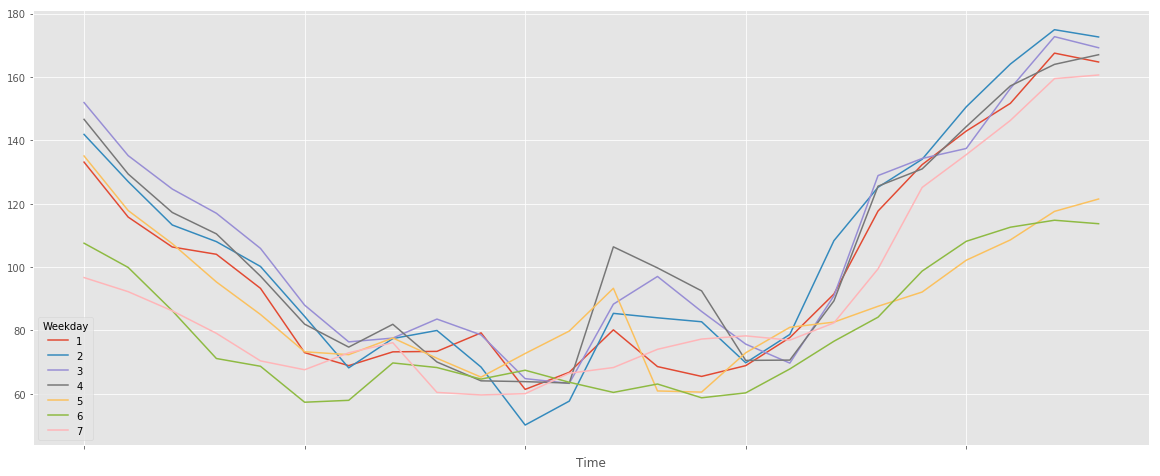

In [160]:
df_dorm_12.groupby(['Time','Weekday']).Usage.mean().unstack().plot(legend = True)
#.Usage.plot(legend = True)

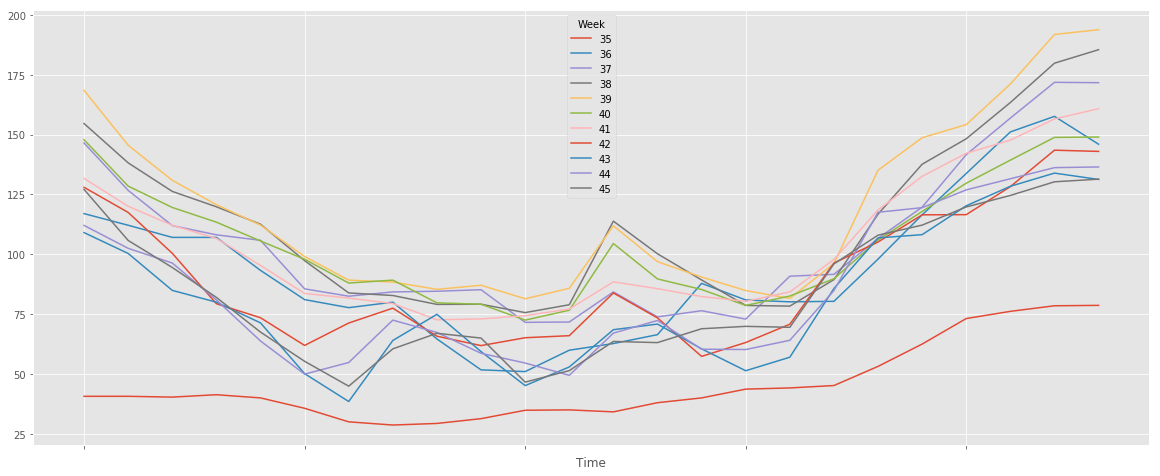

In [161]:
df_dorm_12.groupby(['Time','Week']).Usage.mean().unstack().plot(legend = True)
#.Usage.plot(legend = True)

### 圖七：每周在某一個時刻的用電變化 

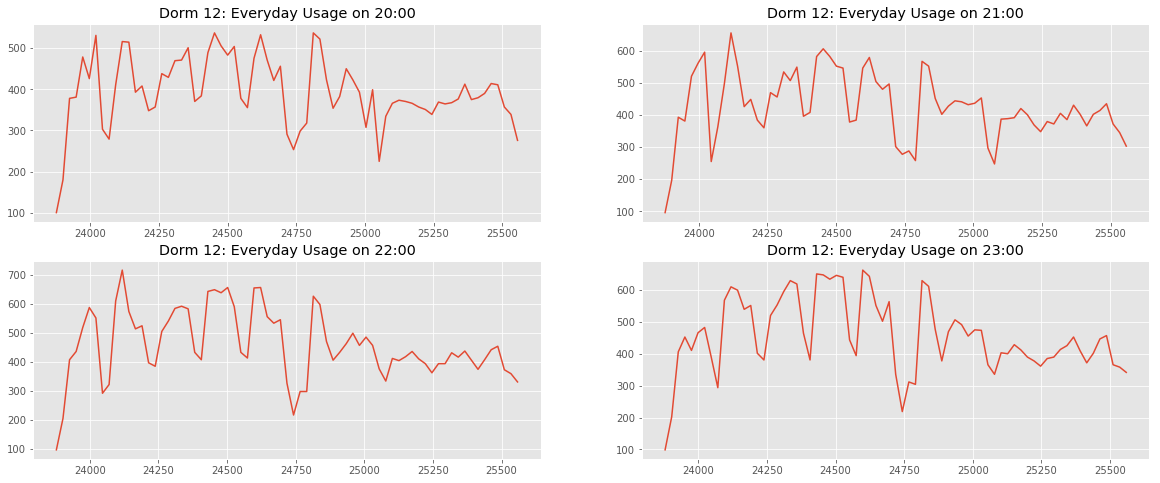

In [30]:
# 觀看某一個小時的用電量，在每天的變化

# df_dorm_12[df_dorm_12.Time == '23:00'].info()
fig, axes = plt.subplots(nrows=2, ncols=2)
df_dorm_12[df_dorm_12.Time == '20:00'].Cost.plot(ax=axes[0,0],title = 'Dorm 12: Everyday Usage on 20:00')
df_dorm_12[df_dorm_12.Time == '21:00'].Cost.plot(ax=axes[0,1],title = 'Dorm 12: Everyday Usage on 21:00')
df_dorm_12[df_dorm_12.Time == '22:00'].Cost.plot(ax=axes[1,0],title = 'Dorm 12: Everyday Usage on 22:00')
df_dorm_12[df_dorm_12.Time == '23:00'].Cost.plot(ax=axes[1,1],title = 'Dorm 12: Everyday Usage on 23:00')

## 成長率

In [40]:
# 使用 .pct_change()
df_dorm_12.groupby(['Week','Weekday']).mean().Cost.pct_change()[-20:]

Week  Weekday
42    7          0.095787
43    1         -0.011279
      2          0.022038
      3          0.049975
      4         -0.040106
      5         -0.014850
      6         -0.045478
      7          0.014454
44    1          0.025330
      2          0.014925
      3          0.054767
      4          0.030769
      5         -0.027752
      6         -0.055409
      7          0.060437
45    1         -0.008860
      2          0.046871
      3         -0.018463
      4         -0.083000
      5         -0.070769
Name: Cost, dtype: float64

/Users/ah-bau/anaconda/lib/python3.5/site-packages/matplotlib/transforms.py:661: RuntimeWarning: invalid value encountered in absolute
  inside = ((abs(dx0 + dx1) + abs(dy0 + dy1)) == 0)


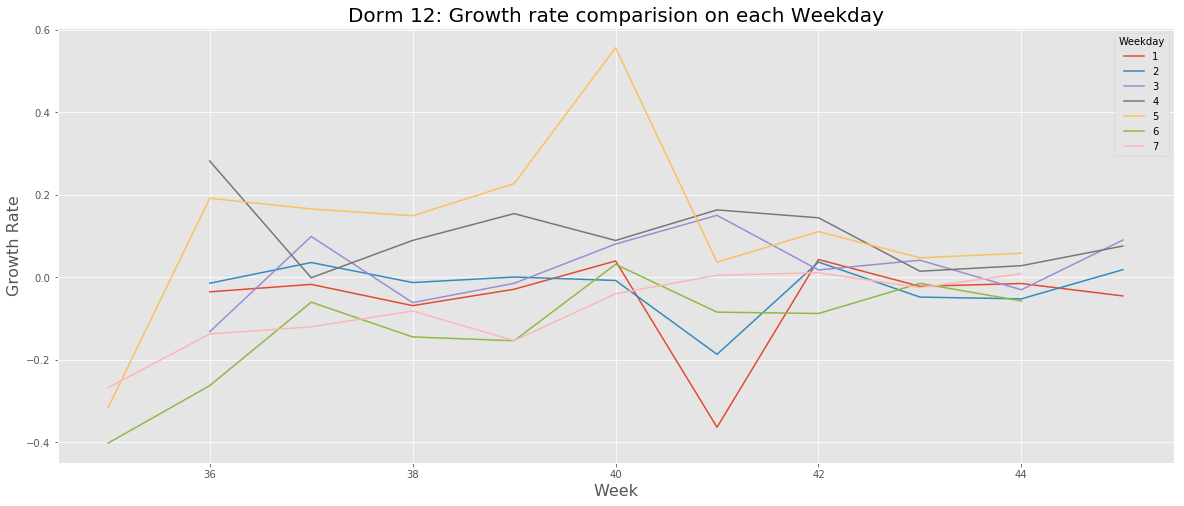

In [218]:
df_dorm_12.groupby(['Week','Weekday']).mean().Cost.pct_change(-1).unstack().plot()
plt.title('Dorm 12: Growth rate comparision on each Weekday', fontsize = 20)
pylab.ylabel('Growth Rate',fontsize = 16)
pylab.xlabel('Week',fontsize = 16) 

In [221]:
#探討peak的成因
df_dorm_12.groupby(['Week','Weekday']).mean().Cost.pct_change(-1).sort_values()[-10:]


Week  Weekday
38    5          0.149568
41    3          0.150613
39    4          0.154692
41    4          0.163728
37    5          0.166040
36    5          0.191959
39    5          0.227447
36    4          0.282185
40    5          0.556947
45    5               NaN
Name: Cost, dtype: float64

                    Usage  Week        Cost
Time  Weekday                              
00:00 1        133.150000  40.5  399.450000
      2        141.900000  40.5  425.700000
      3        151.950000  40.5  455.850000
      4        146.650000  40.5  439.950000
      5        135.090909  40.0  405.272727
      6        107.550000  39.5  322.650000
      7         96.700000  39.5  290.100000
01:00 1        115.800000  40.5  347.400000
      2        127.000000  40.5  381.000000
      3        135.200000  40.5  405.600000
                  Usage      Week      Cost
Time  Weekday                              
00:00 1       -0.061663  0.000000 -0.061663
      2       -0.066140  0.000000 -0.066140
      3        0.036140  0.000000  0.036140
      4        0.085565  0.012500  0.085565
      5        0.256075  0.012658  0.256075
      6        0.112203  0.000000  0.112203
      7       -0.164940 -0.024691 -0.164940
01:00 1       -0.088189  0.000000 -0.088189
      2       -0.060651  0.00000

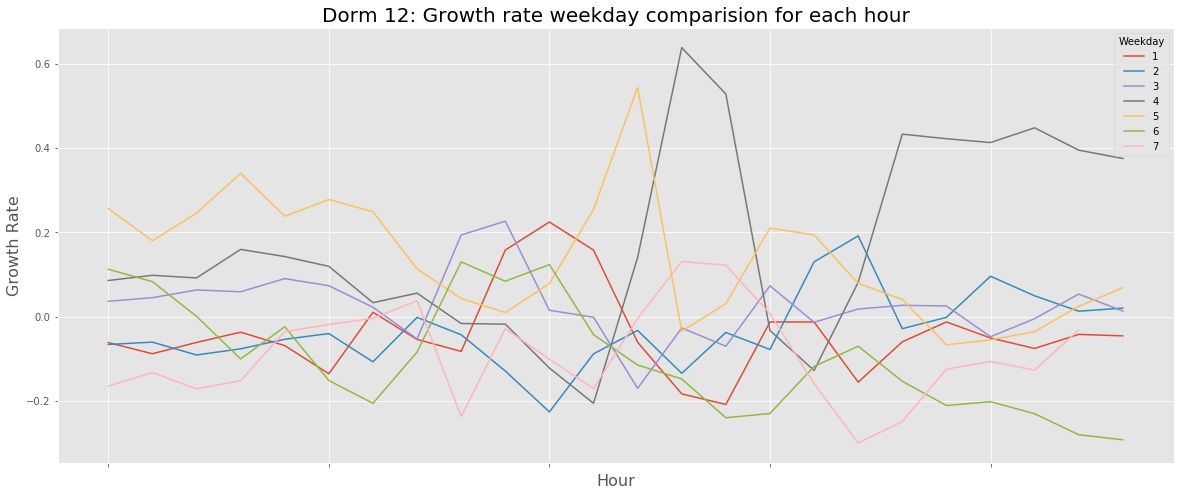

In [236]:
print(df_dorm_12.groupby(['Time','Weekday']).mean()[:10])
print(df_dorm_12.groupby(['Time','Weekday']).mean().pct_change(-1)[:10])
df_dorm_12.groupby(['Time','Weekday']).mean().Cost.pct_change(-1).unstack().plot()
plt.title('Dorm 12: Growth rate weekday comparision for each hour', fontsize = 20)
pylab.ylabel('Growth Rate',fontsize = 16)
pylab.xlabel('Hour',fontsize = 16) 

## 白天 / 晚上用電比率

In [237]:
# df_dorm_12.groupby(['Time','Weekday])
# df_dorm_12_night = df_dorm_12[((df_dorm_12.Time == '03:00') or (df_dorm_12.Time == '04:00') or (df_dorm_12.Time == '05:00'))]
df_dorm_12_night = df_dorm_12.loc[df_dorm_12['Time'].isin(['03:00', '04:00', '05:00', '06:00'])]
df_dorm_12_day = df_dorm_12.loc[df_dorm_12['Time'].isin(['07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00'])]
df_dorm_12_night = df_dorm_12_night.groupby('Date').mean()# 夜晚用電
df_dorm_12_day = df_dorm_12_day.groupby('Date').mean()
(df_dorm_12_day/df_dorm_12_night).head()

,Usage,Weekday,Week,Cost
Date,,,,
2017-09-01,0.866667,1.0,1.0,0.866667
2017-09-02,1.097063,1.0,1.0,1.097063
2017-09-03,1.098039,1.0,1.0,1.098039
2017-09-04,0.885174,1.0,1.0,0.885174
2017-09-05,0.774725,1.0,1.0,0.774725


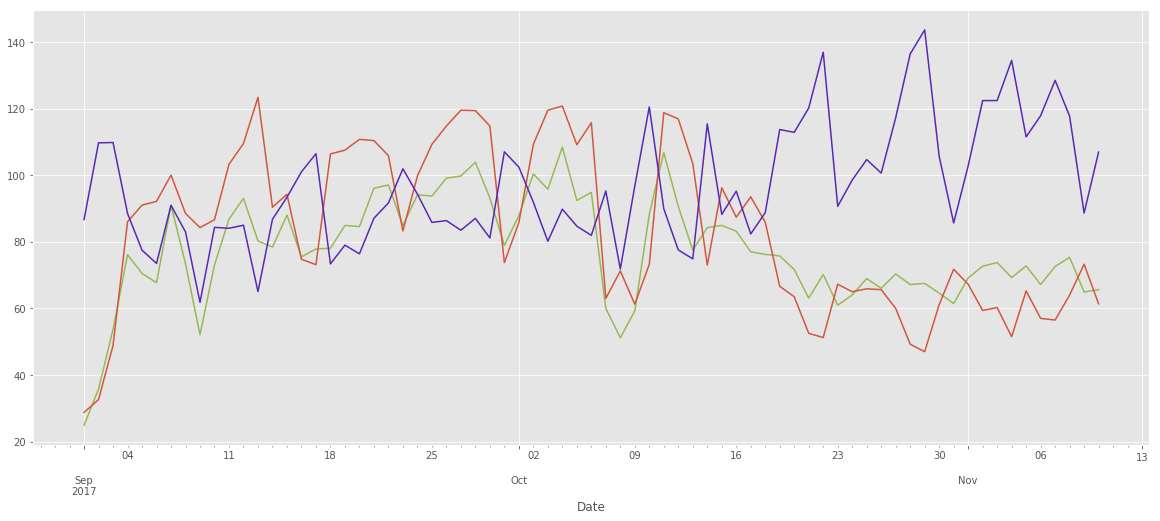

In [245]:
df_dorm_12_day.Usage.plot(color = cGreen)
df_dorm_12_night.Usage.plot(color = cRed)
((df_dorm_12_day/df_dorm_12_night).Usage*100).plot(color = cPurple) 
# bug ： 如何把兩個不同scale的圖畫再一起
# bug ： 如何畫線